In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
import scipy.integrate
import pprint
from FindDataFunctions import *
from pprint import pprint

In [2]:
# path = "/home/helge/Applications/matsim/matsim-bimodal/scenarios/fine_grid/bimodal/output"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/VaryingEll/SmallLinkRouting/UniformDist/Zeta1/"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/VaryingEll/SmallLinkRouting/TaxiDataDist1250New200GridSpacing"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/VaryingEll/SmallLinkRouting/TaxiDataDist1250/"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/VaryingEll/LongLinkRouting/VaryE/Uniform2000Mean100Spacing/"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/VaryingEll/LongLinkRouting/VaryE/Uniform2000Mean100SpacingToLBy2/"
# path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/Manhatten/output/CI_1800mu/150000reqs/"
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/VaryDCutLogNonLocTT5Alpha/"

In [3]:
# dcut_dirs = getBimDirsVaryDCut(path, 100)
# uni_dirs = getUniDirs(path, 100)
# car_dir = getCarDir(path)

# pprint.pprint(dcut_dirs)
# print('\n---\n')
# pprint.pprint(uni_dirs)
# print('\n---\n')
# pprint.pprint(car_dir)
# n_sims = len(dcut_dirs)# - 1

In [4]:
def readData(nReqs):
    load_path = os.path.join(path, str(nReqs)+"reqs")
#     uni_dirs = getUniDirs(load_path, 100)

    saved_path = os.path.join(load_path, "saved.pkl")
    saved_path_car = os.path.join(load_path, "saved_car.pkl")
    # Load car dataframe
    if os.path.isfile(saved_path_car):
        df_car = pd.read_pickle(saved_path_car)
    else:
        car_dir = getCarDir(load_path)
        df_car = getTrips(car_dir, "car")
        df_car.to_pickle(saved_path_car)
    
    # Load bimodal dataframe
    if os.path.isfile(saved_path):
        df = pd.read_pickle(saved_path)
    else:
        dcut_dirs = getBimDirsVaryDCut(load_path, 100)
        cols = ["dcut", "l", "occupancy", "detour", "servability", "req_mean_dist", "drt_wait_time", "drt_wait_time_normalized", "drt_distance"]
        df = pd.DataFrame(np.full((len(dcut_dirs)*len(dcut_dirs[0]),len(cols)), np.nan), columns=cols)
        counter = 0
        for i in range(len(dcut_dirs)):
            for j,dic in enumerate(dcut_dirs[i]):
                row = df.iloc[counter,:]
                try:
                    row.loc["dcut"] = float(dcut_dirs[i][j]["root"].split("/")[-2].replace("dcut",""))
                    row.loc["l"] = float(getEll(dic["root"]))
                    row.loc["occupancy"], _ = getDrtOccupandyAndStandingFrac(dic, False, True)
                    df_detour = getDrtDetours(dic)
                    row.loc["detour"] = df_detour["distanceDetour"].mean()
                    trip_succ = getTripSuccess(dic)
                    row.loc["servability"] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
                    row.loc["req_mean_dist"] = getMeanDist(dic)
                    drt_trips, drt_trips_perperson = getDrtTrips(dic)
                    row.loc["drt_wait_time"] = drt_trips_perperson["waitTime"].mean()
                    df_detour = df_detour.set_index("person")
                    row.loc["drt_wait_time_normalized"] = (drt_trips_perperson["waitTime"]/df_detour["unsharedTime"]).mean()
                    row.loc["drt_distance"] = drt_trips_perperson["travelDistance_m"].mean()
                except KeyError:
                    print("KeyError")
                    pass

                counter+=1
                print("-----")

        df.to_pickle(saved_path)

    
    df = df.sort_values(["dcut", "l"])
    df["efficiency"] = df["occupancy"]/df["detour"]
    df["l"] /= df["req_mean_dist"]
    df["dcut"] /= df["req_mean_dist"]
#     data = np.einsum("ijk->jik", data)
    
    return df, df_car

---
# Visualization

In [25]:
# dcuts, ells, data = readData(10000)
df, df_car = readData(20000)

TypeError: expected str, bytes or os.PathLike object, not NoneType

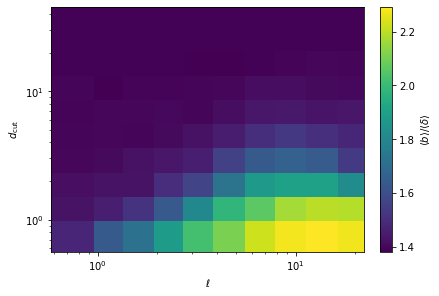

In [14]:
import seaborn as sns

# data_ = np.einsum("ijk->jik", data)
fig, ax = plt.subplots(constrained_layout=True)

df_mod = df[df["l"] < 1000]
df_mod = df_mod[df_mod["dcut"] < 10000]
data = df_mod.pivot(index="l", columns="dcut", values=["efficiency", "servability", "drt_wait_time", "drt_wait_time_normalized" ,"drt_distance", "req_mean_dist"])
Z = data["drt_wait_time_normalized"]
X,Y = np.meshgrid(Z.index.to_numpy(), Z.columns.to_numpy(), indexing='ij')

im = ax.pcolor(X,Y,Z.to_numpy(), shading='auto', linewidth=0)
im.set_edgecolor('face')
# ax = sns.heatmap(data[:,:,0])
plt.colorbar(im, label=r"$\langle b\rangle/\langle\delta\rangle$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$d_\mathrm{cut}$")

plt.show()

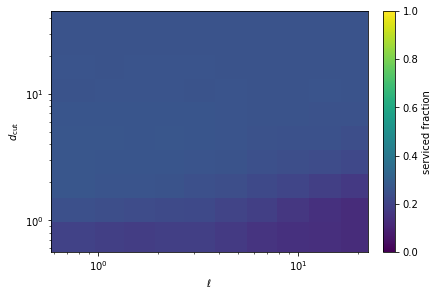

In [34]:
fig, ax = plt.subplots(constrained_layout=True)

im = ax.pcolor(X,Y,data["servability"].to_numpy(), shading='auto', vmin=0, vmax=1, linewidth=0)
im.set_edgecolor('face')
# ax = sns.heatmap(data[:,:,0])
plt.colorbar(im, label="serviced fraction", )
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$d_\mathrm{cut}$")

plt.show()

---

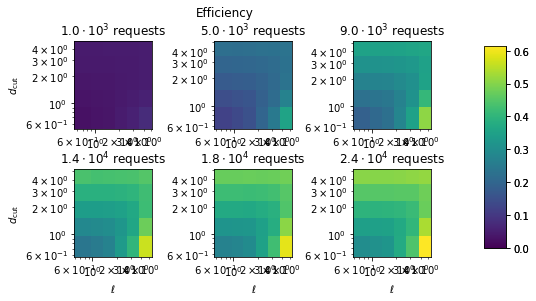

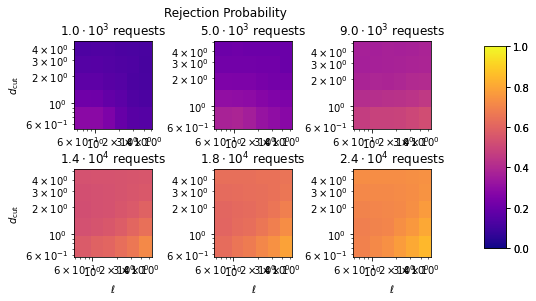

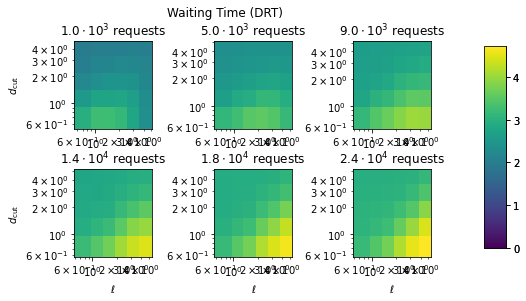

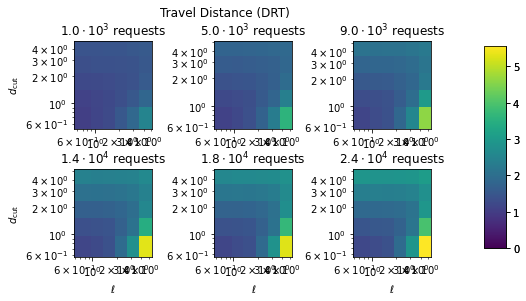

In [41]:
fig1, axes1 = plt.subplots(2,3, constrained_layout=True)
fig2, axes2 = plt.subplots(2,3, constrained_layout=True)
fig3, axes3 = plt.subplots(2,3, constrained_layout=True)
fig4, axes4 = plt.subplots(2,3, constrained_layout=True)
fig_list = [fig1, fig2, fig3, fig4]
fig_titles = ["Efficiency", "Rejection Probability", "Waiting Time (DRT)", "Travel Distance (DRT)"]
save_names = ["Efficiency", "Rejection", "WaitingTimeDrt", "TravelDistanceDrt"]
axes_list = [axes1, axes2, axes3, axes4]
reqs = np.array([1000,5000,9000,14000,18000,24000])
reqs_log = np.log10(reqs).astype(np.int64)
coeffs = np.round(reqs/10**reqs_log,1)
efficiencies = []
servabilities = []
drt_wait_times = []
drt_distances = []
efficiency_max = 0
drt_wait_time_max = 0
drt_distance_max = 0

for i,r in enumerate(reqs):
    df, df_car = readData(r)
#     df = df[df["l"] < 5]
#     df = df[df["dcut"] < 5]
    df[""]
    data = df.pivot(index="l", columns="dcut", values=["efficiency", "servability", "drt_wait_time", "drt_wait_time_normalized", "drt_distance", "req_mean_dist"])
    efficiencies.append(data["efficiency"])
    servabilities.append(1 - data["servability"])
    drt_wait_times.append(data["drt_wait_time_normalized"])
    drt_distances.append(data["drt_distance"]/data["req_mean_dist"])
    efficiency_max = np.maximum(efficiency_max, efficiencies[i].to_numpy().max())
    drt_wait_time_max = np.maximum(drt_wait_time_max, drt_wait_times[i].to_numpy().max())
    drt_distance_max = np.maximum(efficiency_max, drt_distances[i].to_numpy().max())
    
ims = []
for i in range(len(reqs)):
    X,Y = np.meshgrid(efficiencies[i].index.to_numpy(), efficiencies[i].columns.to_numpy(), indexing='ij')
    im1 = axes1[i//3,i%3].pcolor(X,Y,efficiencies[i].to_numpy(), shading='auto', vmin=0, vmax=efficiency_max)#, linewidth=0)
    im2 = axes2[i//3,i%3].pcolor(X,Y,servabilities[i].to_numpy(), shading='auto', cmap="plasma", vmin=0, vmax=1)#, linewidth=0)
    im3 = axes3[i//3,i%3].pcolor(X,Y,drt_wait_times[i].to_numpy(), shading='auto', vmin=0, vmax=drt_wait_time_max)#, linewidth=0)
    im4 = axes4[i//3,i%3].pcolor(X,Y,drt_distances[i].to_numpy(), shading='auto', vmin=0, vmax=drt_distance_max)#, linewidth=0)
    ims =[im1, im2, im3, im4]
    for im in ims:
        im.set_edgecolor('face')
    
    for axes in axes_list:
        axes[i//3,i%3].set_xscale("log")
        axes[i//3,i%3].set_yscale("log")

for i,axes in enumerate(axes_list):
    axes[1,0].set_xlabel(r"$\ell$")
    axes[1,1].set_xlabel(r"$\ell$")
    axes[1,2].set_xlabel(r"$\ell$")
    axes[1,0].set_ylabel(r"$d_\mathrm{cut}$")
    axes[0,0].set_ylabel(r"$d_\mathrm{cut}$")
#     axes[0,0].set_title(rf"{reqs[0]:.1E}$a =b$ requests")
#     axes[0,1].set_title(rf"{reqs[1]:.1E} requests")
#     axes[0,2].set_title(rf"{reqs[2]:.1E} requests")
#     axes[1,0].set_title(rf"{reqs[3]:.1E} requests")
#     axes[1,1].set_title(rf"{reqs[4]:.1E} requests")
#     axes[1,2].set_title(rf"{reqs[5]:.1E} requests")
    axes[0,0].set_title(rf"${coeffs[0]}\cdot 10^{reqs_log[0]}$ requests")
    axes[0,1].set_title(rf"${coeffs[1]}\cdot 10^{reqs_log[1]}$ requests")
    axes[0,2].set_title(rf"${coeffs[2]}\cdot 10^{reqs_log[2]}$ requests")
    axes[1,0].set_title(rf"${coeffs[3]}\cdot 10^{reqs_log[3]}$ requests")
    axes[1,1].set_title(rf"${coeffs[4]}\cdot 10^{reqs_log[4]}$ requests")
    axes[1,2].set_title(rf"${coeffs[5]}\cdot 10^{reqs_log[5]}$ requests")
for i,fig in enumerate(fig_list):
    cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
    fig.colorbar(ims[i], cax=cbar_ax)
for i,fig in enumerate(fig_list):
    cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
    fig.colorbar(ims[i], cax=cbar_ax)
    fig.suptitle(fig_titles[i])
#     fig.savefig(f"figures/{save_names[i]}Small.jpg", bbox_inches="tight", dpi=300)
    
plt.show()

In [ ]:
def plotDists(path):
    system_size = 10000
    makePeriodic = lambda x: x if x < system_size/2 else system_size - x
    columns = ["first_act_x", "first_act_y", "last_act_x", "last_act_y"]
    df = pd.read_csv(path, sep=";").loc[:,columns]
    diffX = np.abs(df["last_act_x"] - df["first_act_x"])
    diffX = diffX.apply(makePeriodic)
    diffY = np.abs(df["last_act_y"] - df["first_act_y"])
    diffY = diffY.apply(makePeriodic)
    df["mean_dist"] = np.sqrt(diffX**2 + diffY**2)
    df["mean_dist"].plot(kind="hist", bins=30)
    print(df["mean_dist"].mean())
    
    
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/VaryDCutLogNonLoc/1500reqs/100drt/0.5dcut/l_2400/bimodal/output_persons.csv.gz"

plotDists(path)